## 1. Tổng quan bộ dataset

- Books data: Cung cấp tổng quan chi tiết về thông tin sách bao gồm tên sách, năm xuất bản cũng như tác giả của cuốn sách
- Users data: Cung cấp tổng quan chi tiết về từng người dùng, chẳng hạn như vị trí của người dùng cũng như độ tuổi của người dùng
- Rating data: Dữ liệu được tổng hợp cơ bản về cách mỗi người dùng xếp hạng từng cuốn sách

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
import missingno as msno

## 2. Tiền xử lý data

### 2.1 Books dataset

In [120]:
df_books = pd.read_csv('C:/duong/github/Machine-Learning-self-study/archive/Books.csv', delimiter=",", usecols = [0,1,2,3,4])
print(df_books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB
None


C:\Users\kieub\AppData\Local\Temp\ipykernel_2088\2155556344.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('C:/duong/github/Machine-Learning-self-study/archive/Books.csv', delimiter=",", usecols = [0,1,2,3,4])


Ta có thể thấy cột Year-Of-Publication đang ở dạng object, vì vậy ta cần phải chuyển nó về int

In [121]:
try:
    df_books['Year-Of-Publication']  = df_books['Year-Of-Publication'].astype(int)
except Exception as e:
    print(e)

invalid literal for int() with base 10: 'DK Publishing Inc'


Chotto, có những sách có trường Year-Of-Publication có giá trị là 'DK Publishing Inc'. Vậy ta sẽ in thử những quyển đó là quyển nào

In [122]:
print(df_books[df_books['Year-Of-Publication'] == 'DK Publishing Inc'])

              ISBN                                         Book-Title   
209538  078946697X  DK Readers: Creating the X-Men, How It All Beg...  \
221678  0789466953  DK Readers: Creating the X-Men, How Comic Book...   

       Book-Author Year-Of-Publication   
209538        2000   DK Publishing Inc  \
221678        2000   DK Publishing Inc   

                                                Publisher  
209538  http://images.amazon.com/images/P/078946697X.0...  
221678  http://images.amazon.com/images/P/0789466953.0...  


Giờ ta sẽ chuyển data ở cột Year-Of-Publication sang dạng số, data nào không convert được sẽ ở dạng NaN

In [123]:
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'],errors='coerce')
print(df_books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271358 non-null  object 
 3   Year-Of-Publication  271357 non-null  float64
 4   Publisher            271358 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.4+ MB
None


Có thể thấy cột Year-Of-Publication tuy convert sang số nhưng lại ở dạng float64, bây giờ chúng ta sẽ loại bỏ các record có value là NaN và ép kiểu cột này thành int32

In [124]:
df_books = df_books.dropna()
df_books['Year-Of-Publication'] = df_books['Year-Of-Publication'].astype(int)
print(df_books.info())

<class 'pandas.core.frame.DataFrame'>
Index: 271353 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271353 non-null  object
 1   Book-Title           271353 non-null  object
 2   Book-Author          271353 non-null  object
 3   Year-Of-Publication  271353 non-null  int32 
 4   Publisher            271353 non-null  object
dtypes: int32(1), object(4)
memory usage: 11.4+ MB
None


In [125]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


Vậy là xử lý xong trường Year-Of-Publication của Books dataset

Giờ vẽ thử cái đồ thị biểu thị số lượng sách được phân phối ở mỗi năm

<BarContainer object of 116 artists>

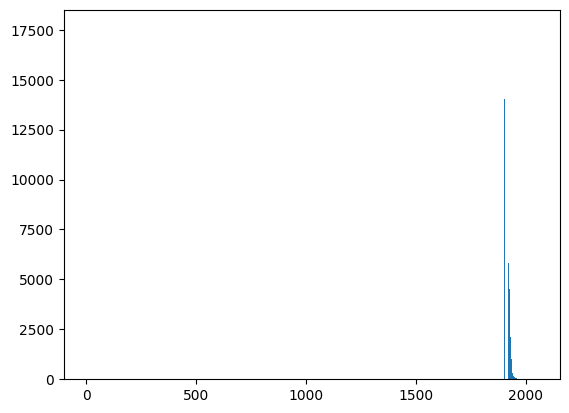

In [126]:
plt.bar(pd.DataFrame(df_books['Year-Of-Publication'].value_counts()).sort_index().index, np.array(df_books['Year-Of-Publication'].value_counts()), width = 1)

Có 2 điểm nhận xét ở đồ thị ở trên:
- Hầu hết sách được publish từ 1700~2000s
- Vẫn có những quyển publish bé hơn 1000s, nên giờ ta sẽ impute value của những record này

In [128]:
# Tạo bản sao của cột "Year-Of-Publication"
df_books_imputed = df_books.copy()

# Thay thế các giá trị năm xuất bản dưới 1000 bằng NaN
df_books_imputed.loc[df_books_imputed['Year-Of-Publication'] < 1000, 'Year-Of-Publication'] = np.nan

# Tính mode mean của cột "Year-Of-Publication"
year_mean = df_books_imputed['Year-Of-Publication'].mode()[0]

# Thay thế các giá trị NaN bằng mode mean
df_books_imputed['Year-Of-Publication'].fillna(year_mean, inplace=True)

df_books = df_books_imputed

print(df_books.loc[df_books['Year-Of-Publication'] < 1000])


Empty DataFrame
Columns: [ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher]
Index: []


### 2.2 Users dataset